In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [11]:
!pip install -q mlflow
!pip install -q python-dotenv

In [12]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [13]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [14]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [15]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2023.pkl'))

In [16]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [17]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [18]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [19]:
df = pipe_clean.fit_transform(df)

In [20]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
2,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
3,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
4,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
5,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [21]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.20598116428925484

In [22]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [23]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [24]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [25]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [26]:
mlflow.set_experiment('Ensemble Random Forest & XGBoost')

2023/11/11 00:11:12 INFO mlflow.tracking.fluent: Experiment with name 'Ensemble Random Forest & XGBoost' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/5', creation_time=1699661473312, experiment_id='5', last_update_time=1699661473312, lifecycle_stage='active', name='Ensemble Random Forest & XGBoost', tags={}>

In [27]:
params_1 = {
    'colsamples_bytree': .7,
    'learning_rate': .2,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': .7,
    'random_state': 23
}

params_2 = {
    'max_depth': 8,
    'max_features': .5,
    'min_samples_split': 10,
    'n_estimators': 220,
    'random_state': 23
}

In [28]:
with mlflow.start_run():
    estimator_1 = xgb.XGBRegressor(**params_1)
    estimator_2 = RandomForestRegressor(**params_2)

    model = VotingRegressor([('xgb', estimator_1), ('rf', estimator_2)], weights = [.7, .3], verbose = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    params = model.get_params()

    predicted_targets = mod.predict_model(model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_ens(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

[Voting] ...................... (1 of 2) Processing xgb, total=   1.3s
[Voting] ....................... (2 of 2) Processing rf, total=  57.4s
[Voting] ...................... (1 of 2) Processing xgb, total=   4.8s
[Voting] ....................... (2 of 2) Processing rf, total=  49.0s
[Voting] ...................... (1 of 2) Processing xgb, total=   5.3s
[Voting] ....................... (2 of 2) Processing rf, total=  48.2s
[Voting] ...................... (1 of 2) Processing xgb, total=   4.5s
[Voting] ....................... (2 of 2) Processing rf, total=  53.1s
[Voting] ...................... (1 of 2) Processing xgb, total=   4.5s
[Voting] ....................... (2 of 2) Processing rf, total=  48.9s
[Voting] ...................... (1 of 2) Processing xgb, total=   4.1s
[Voting] ....................... (2 of 2) Processing rf, total=  48.6s
[Voting] ...................... (1 of 2) Processing xgb, total=   5.3s
[Voting] ....................... (2 of 2) Processing rf, total=  48.2s
[Votin

In [29]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.013053,0.014322,0.028889
R2,0.993012,0.976352,0.732518


In [30]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [31]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.524318
173,2017,James Harden,0.746,0.638708
261,2017,Kawhi Leonard,0.495,0.456065
221,2017,LeBron James,0.330,0.362867
425,2017,Isaiah Thomas,0.080,0.232859
98,2017,Stephen Curry,0.051,0.240665
16,2017,Giannis Antetokounmpo,0.007,0.077643
453,2017,John Wall,0.007,0.082393
100,2017,Anthony Davis,0.002,0.091888


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.841189
249,2018,LeBron James,0.731,0.408487
122,2018,Anthony Davis,0.441,0.174246
298,2018,Damian Lillard,0.205,0.149174
508,2018,Russell Westbrook,0.075,0.250454
16,2018,Giannis Antetokounmpo,0.074,0.062165
143,2018,Kevin Durant,0.065,0.210008
130,2018,DeMar DeRozan,0.032,0.037219
7,2018,LaMarcus Aldridge,0.006,0.037884


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.654225
207,2019,James Harden,0.768,0.567802
184,2019,Paul George,0.352,0.154210
270,2019,Nikola Jokić,0.210,0.213699
124,2019,Stephen Curry,0.173,0.117300
305,2019,Damian Lillard,0.068,0.164610
155,2019,Joel Embiid,0.049,0.047876
150,2019,Kevin Durant,0.025,0.183817
301,2019,Kawhi Leonard,0.013,0.213051


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.703535
251,2020,LeBron James,0.746,0.527542
199,2020,James Harden,0.363,0.383935
134,2020,Luka Dončić,0.198,0.163172
294,2020,Kawhi Leonard,0.166,0.178162
123,2020,Anthony Davis,0.081,0.385851
396,2020,Chris Paul,0.026,0.014804
297,2020,Damian Lillard,0.023,0.151567
262,2020,Nikola Jokić,0.018,0.060712


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.516062
146,2021,Joel Embiid,0.580,0.100682
116,2021,Stephen Curry,0.449,0.213109
12,2021,Giannis Antetokounmpo,0.345,0.337603
396,2021,Chris Paul,0.138,-0.003043
130,2021,Luka Dončić,0.042,0.151992
297,2021,Damian Lillard,0.038,0.184231
421,2021,Julius Randle,0.020,0.079747
439,2021,Derrick Rose,0.010,0.000123


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.493359
162,2022,Joel Embiid,0.706,0.330040
12,2022,Giannis Antetokounmpo,0.595,0.302682
59,2022,Devin Booker,0.216,0.075964
141,2022,Luka Dončić,0.146,0.300782
526,2022,Jayson Tatum,0.043,0.111462
390,2022,Ja Morant,0.010,0.203202
126,2022,Stephen Curry,0.004,0.017095
438,2022,Chris Paul,0.002,0.104993


,,Player,Share,PredShare
Rk,Season,,,
143,2023,Joel Embiid,0.915,0.461091
249,2023,Nikola Jokić,0.674,0.505618
11,2023,Giannis Antetokounmpo,0.606,0.403771
465,2023,Jayson Tatum,0.280,0.259502
164,2023,Shai Gilgeous-Alexander,0.046,0.174499
338,2023,Donovan Mitchell,0.030,0.160479
428,2023,Domantas Sabonis,0.027,0.139545
125,2023,Luka Dončić,0.010,0.157774
108,2023,Stephen Curry,0.005,0.015914


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2017,Álex Abrines,0.0,0.000572
4,2017,Arron Afflalo,0.0,0.000228
5,2017,Alexis Ajinça,0.0,0.000174
7,2017,LaMarcus Aldridge,0.0,0.000451
8,2017,Lavoy Allen,0.0,0.000216
...,...,...,...,...
525,2023,Vince Williams Jr.,0.0,0.000235
526,2023,Ziaire Williams,0.0,0.000235
531,2023,Christian Wood,0.0,0.022787


In [32]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.117864
35,2020,Bradley Beal,0.0,0.132277
525,2020,Trae Young,0.0,0.116310
38,2021,Bradley Beal,0.0,0.120199
140,2021,Kevin Durant,0.0,0.125188
244,2021,Kyrie Irving,0.0,0.105722
186,2023,Tyrese Haliburton,0.0,0.113623
190,2023,James Harden,0.0,0.123864
267,2023,Louis King,0.0,0.126546


In [33]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

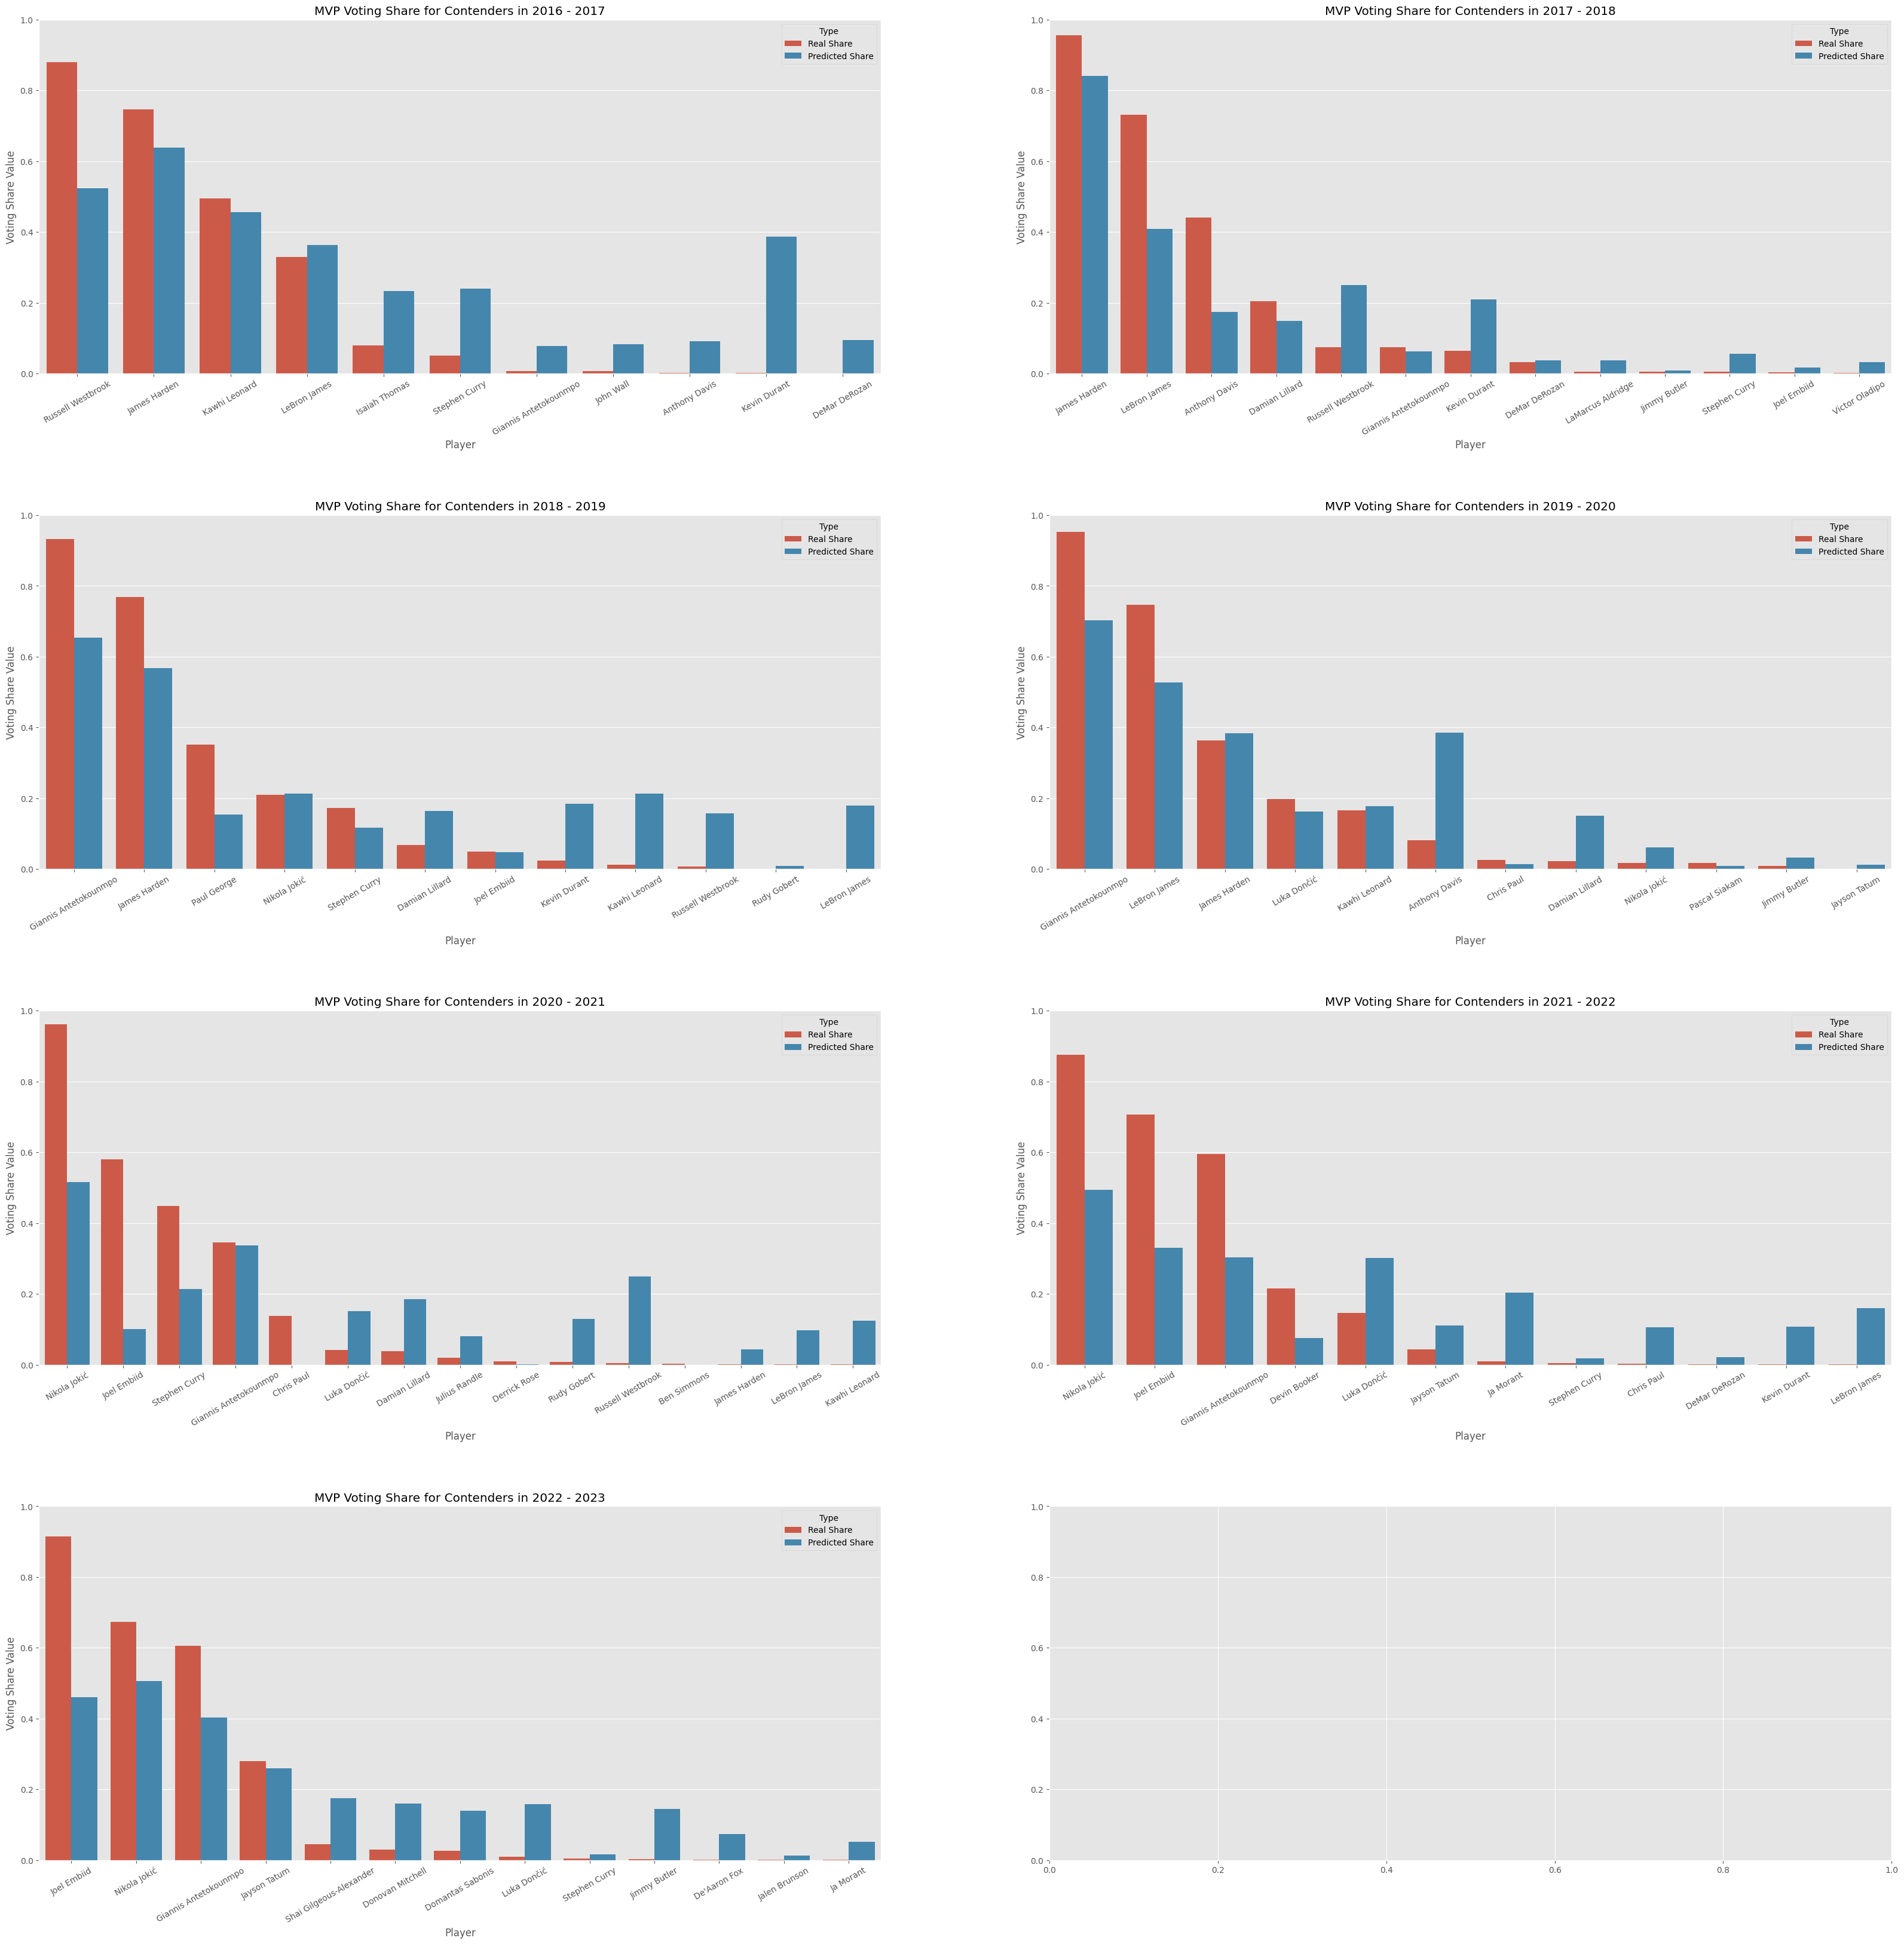

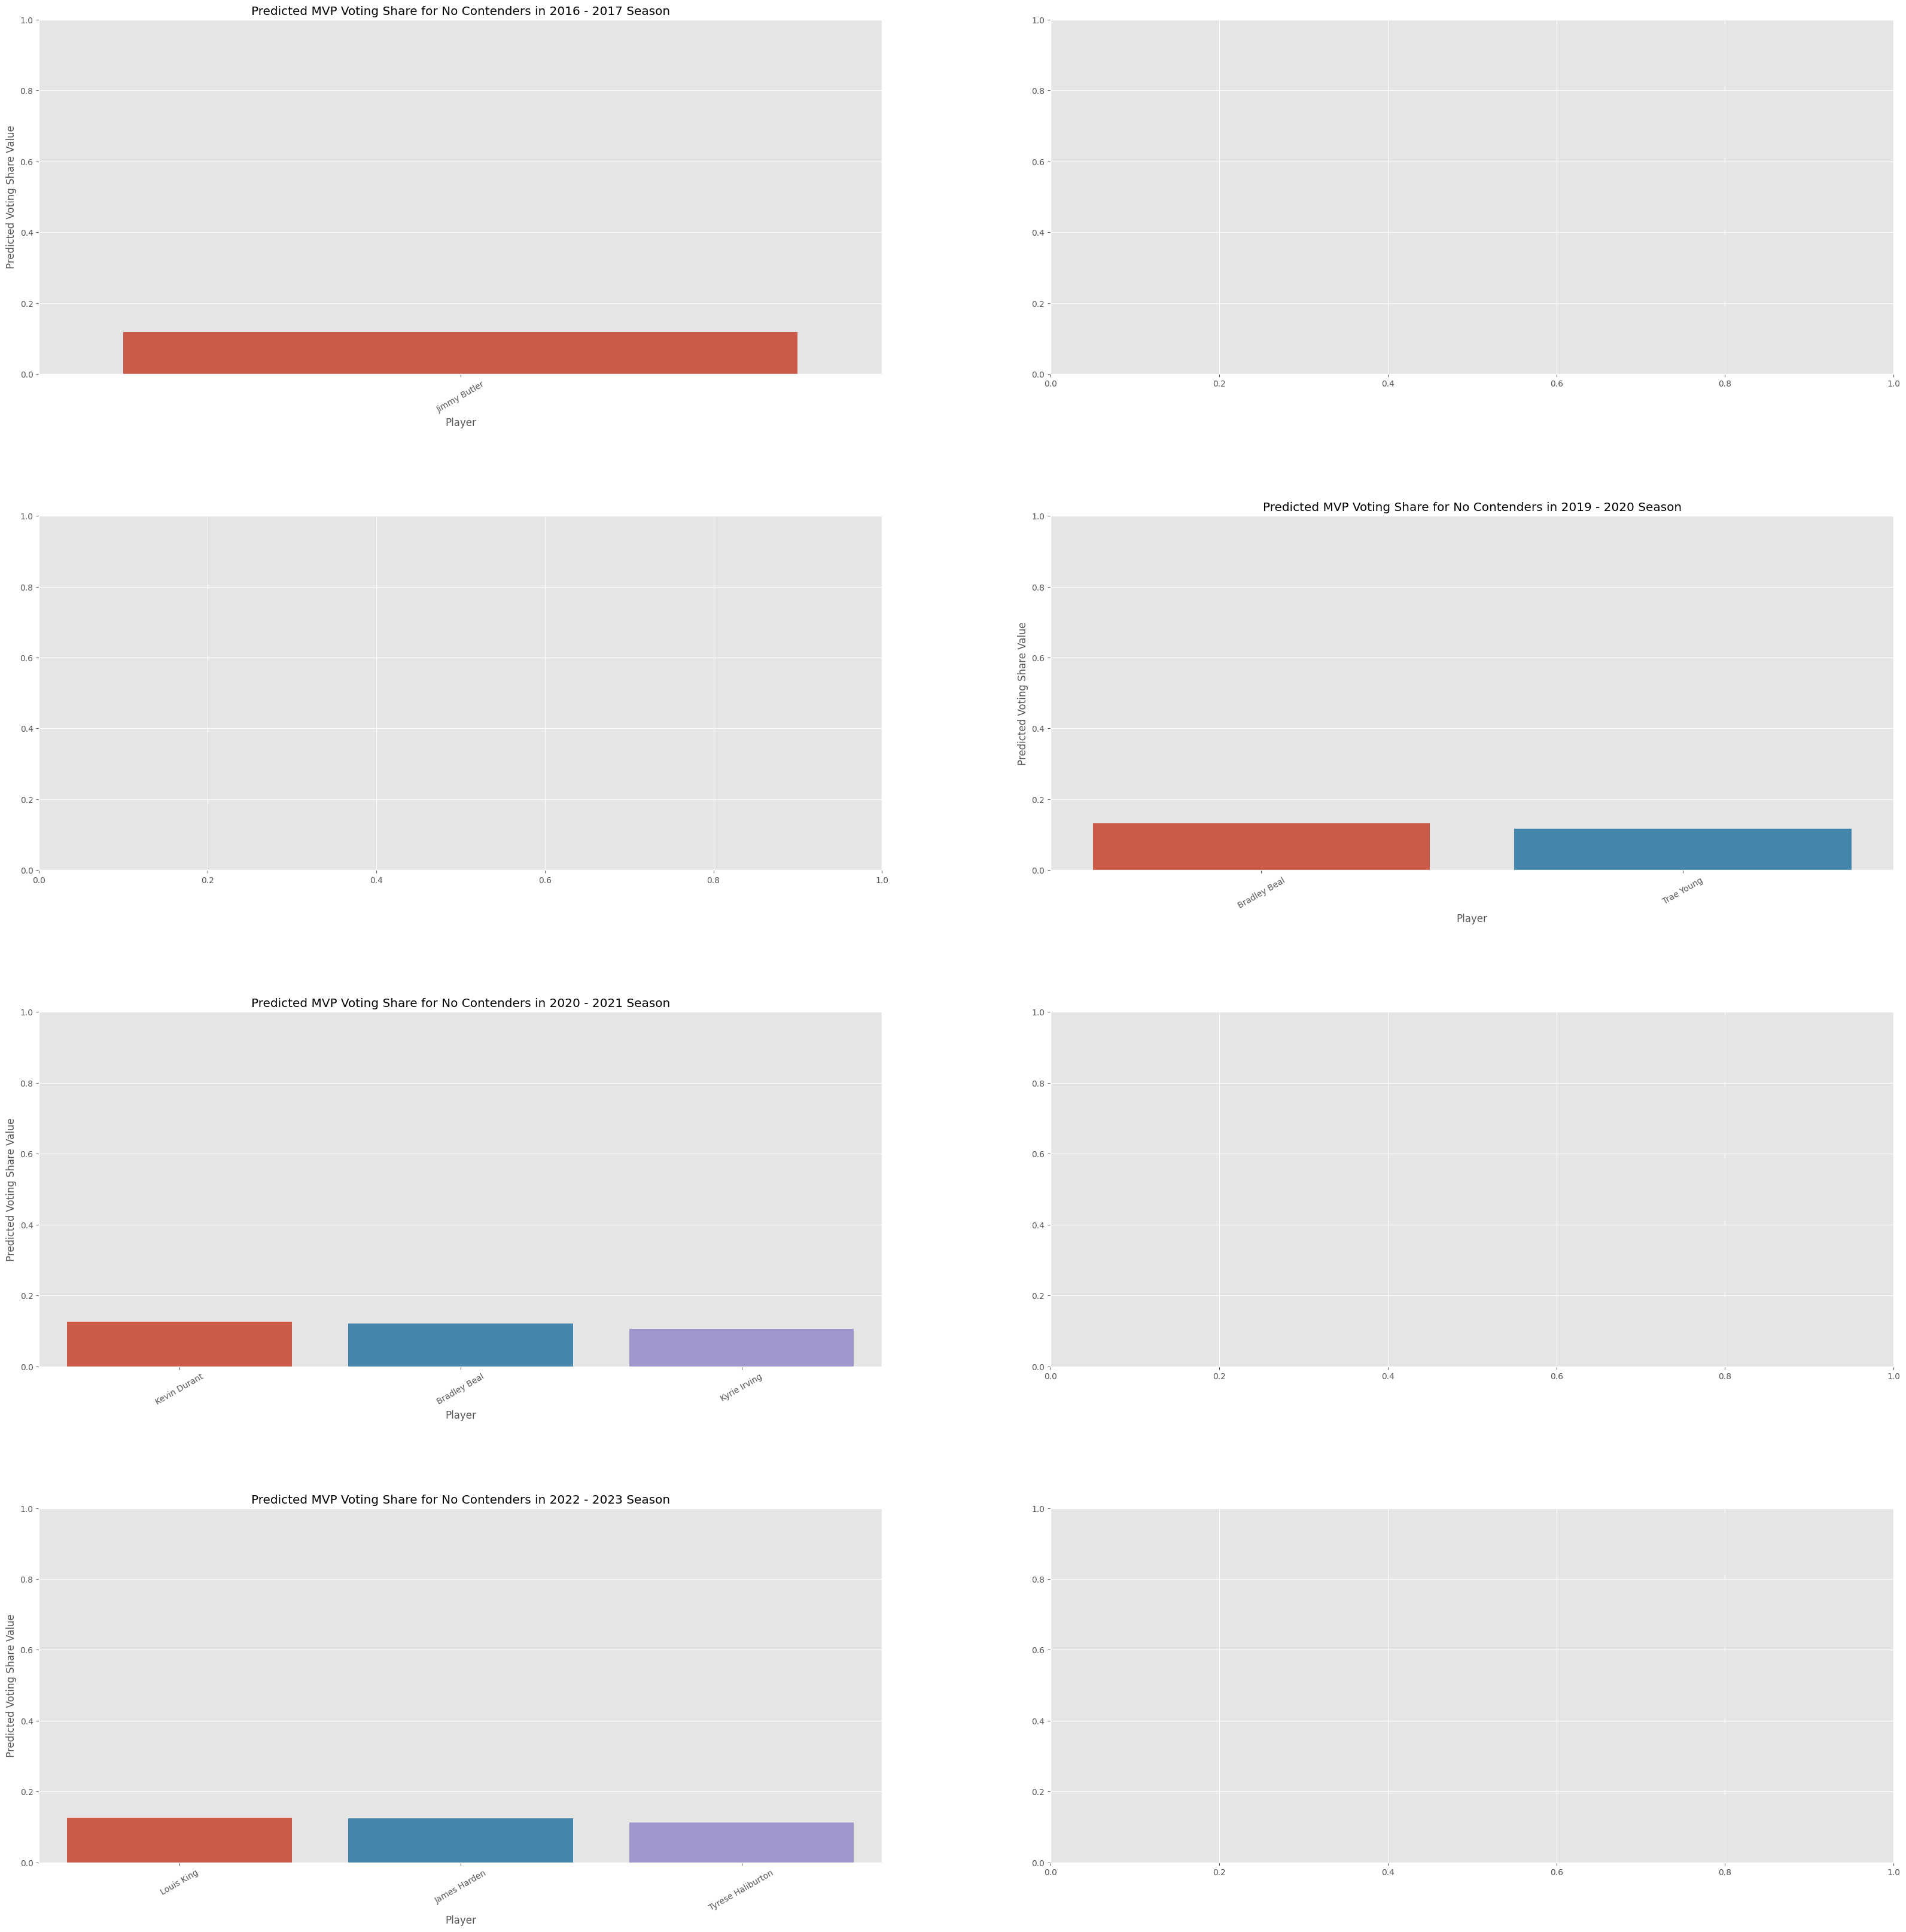

In [34]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)